In [1]:

input_file = 'C:\\Users\\hp\\Desktop\\bg\\AA.jpg'
background_url = 'https://images.unsplash.com/photo-1475139441338-693e7dbe20b6?auto=format&fit=crop&w=640&q=427'

foreground_file = './foreground.png'
output_file = './final.jpg'

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2495292505.py, line 1)

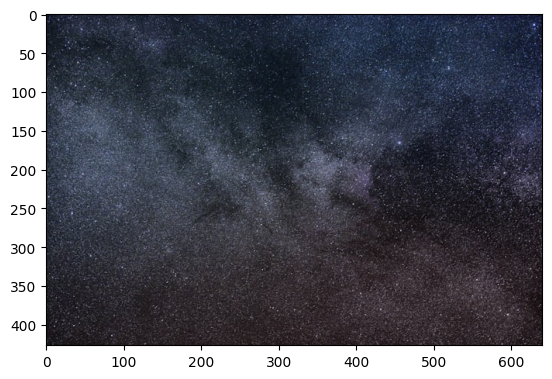

In [3]:
from urllib.request import urlretrieve
from PIL import Image
from matplotlib import pyplot as plt




In [4]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

def load_model():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)  # Using a higher capacity model
    model.eval()
    return model

def make_transparent_foreground(pic, mask):
    mask = Image.fromarray(mask)
    mask = mask.resize(pic.size, Image.BILINEAR)
    mask = np.array(mask)


    pic = pic.convert("RGBA")
    data = np.array(pic)

    if mask.shape[0] != data.shape[0] or mask.shape[1] != data.shape[1]:
        raise ValueError(f"Mask shape {mask.shape} does not match image shape {data.shape[:2]}")


    white_areas = (mask == 0)
    data[white_areas, 3] = 0

    return Image.fromarray(data)

def remove_background(model, input_file):
    input_image = Image.open(input_file).convert("RGB")
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()


    mask = (output_predictions > 0).astype(np.uint8) * 255


    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    foreground = make_transparent_foreground(input_image, mask)

    return foreground, mask

In [5]:
deeplab_model = load_model()
foreground, bin_mask = remove_background(deeplab_model, input_file)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 97.9MB/s]


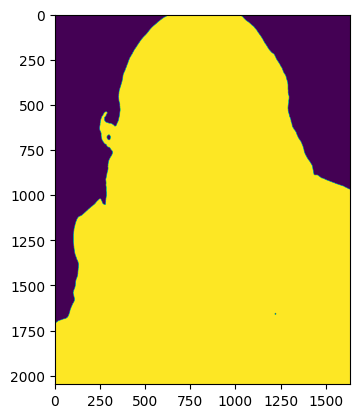

In [6]:
plt.imshow(bin_mask)

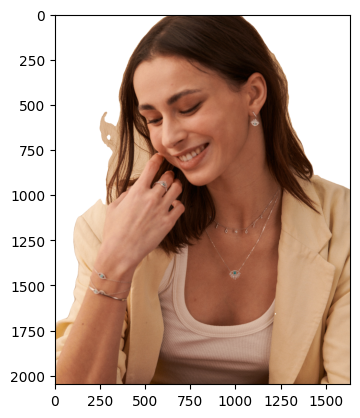

In [7]:
plt.imshow(foreground)

In [8]:
img_fg = foreground
if foreground_file.endswith(('jpg', 'jpeg')):
  img_fg = img_fg.convert('RGB')

img_fg.save(foreground_file)

In [9]:
def custom_background(background_file, foreground):
  final_foreground = Image.fromarray(foreground)
  background = Image.open(background_file)
  x = (background.size[0]-final_foreground.size[0])/2 + 0.5
  y = (background.size[1]-final_foreground.size[1])/2 + 0.5
  box = (x, y, final_foreground.size[0] + x, final_foreground.size[1] + y)
  crop = background.crop(box)
  final_image = crop.copy()
  paste_box = (0, final_image.size[1] - final_foreground.size[1], final_image.size[0], final_image.size[1])
  final_image.paste(final_foreground, paste_box, mask=final_foreground)
  return final_image

In [10]:
final_image = custom_background(background_file, foreground)
plt.imshow(final_image)

TypeError: expected string or buffer

In [ ]:
final_image.save(output_file)